In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import os
os.getcwd()

'/Users/vkalghatgi/Dropbox/Protocol_Labs/mechafil-jax-notebooks/baseline_project/Hybrid_Consensus_Pledge'

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import os
from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp
import pandas as pd

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import scenario_generator.utils as u
import scenario_generator.curated as curated

import warnings 
warnings.filterwarnings('ignore')

In [4]:
# Constants 
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB

# Useful Function
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['qa_day_onboarded_power_pib']*PIB)
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / (cil_rbp.network_QAP_EIB * EIB)
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    return cil_rbp

## Data 

In [5]:
token = '/Users/vkalghatgi/Dropbox/Mac/Desktop/vik_spacescope_auth.json'

start_date = date(2023, 7, 15)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*8
end_date = current_date + timedelta(days=forecast_length)
offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-15 2023-08-07 2031-08-05


5.941741943359375 6.668217468261718 5.228692626953125 0.7213837714820723 0.8713632030566256


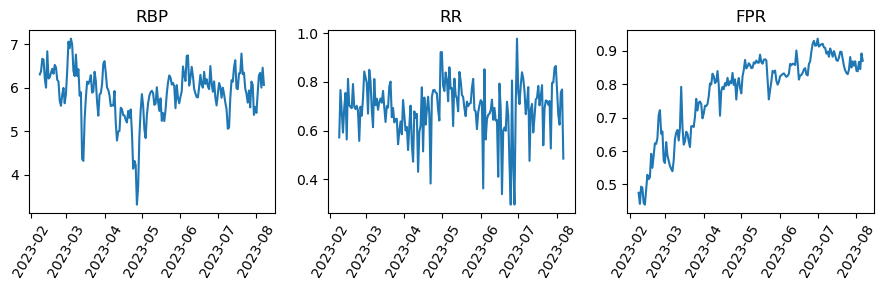

In [6]:
# Quick EDA of Recent Onboarding and Renewal Trends 
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=180), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=180), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=180), current_date)

smoothed_last_historical_rbp_median = np.median(hist_rbp[-180:])
smoothed_last_historical_rbp_optimistic = np.percentile(hist_rbp[-180:], 95)
smoothed_last_historical_rbp_pessimistic = np.percentile(hist_rbp[-180:], 10)
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp_median, smoothed_last_historical_rbp_optimistic, 
      smoothed_last_historical_rbp_pessimistic, 
      smoothed_last_historical_rr, smoothed_last_historical_fpr)

# Plot 
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()
plt.show()

In [7]:
g = np.log(2)/(365)
# Define Scenarios From this Document https://docs.google.com/document/d/1aD6mvbkisey_iUQ6VTuiicdYXYeVG5mDXdhEsVd0kPY/edit#heading=h.7f1lntj8edxh
optimistic = 15
pessimistic = 3
status_quo = 6

baseline = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

scenarios = {
    'status_quo': {
        'rbp': np.ones(forecast_length) * status_quo,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'optimistic': {
        'rbp': curated.linear_increase_and_plateau(
            smoothed_last_historical_rbp_optimistic,
            smoothed_last_historical_rbp_optimistic * 10,
            forecast_length,
            forecast_length
        ), 
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'pessimistic': {
        'rbp': np.ones(forecast_length) * pessimistic,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]

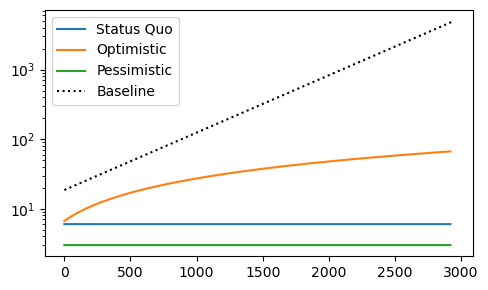

In [8]:
# plot the RBP trajectories for comparison
plt.figure(figsize=(5,3))
plt.plot(scenarios['status_quo']['rbp'], label='Status Quo')
plt.plot(scenarios['optimistic']['rbp'], label='Optimistic')
plt.plot(scenarios['pessimistic']['rbp'], label='Pessimistic')
plt.plot(baseline, linestyle=':', color='k', label='Baseline')
plt.legend()
plt.yscale('log')
plt.tight_layout()

#plt.savefig(os.path.join(save_dir, 'rbp_trajectories.png'))

## Simulations

In [133]:
# Parameter Setting
gamma_weights = [0.85, 0.9, 0.95, 0.99, 1]
gamma_weight_types = [0,1,2]
lock_target_val = 0.3
lock_target_trajectory = jnp.ones(forecast_length) * lock_target_val
sector_duration = 365
scenario2results_full = {}

nan_array = np.full(sector_duration-1, np.nan)
for scenario_name, trajectories in scenarios.items(): 
    rbp = jnp.array(trajectories['rbp'])
    rr = jnp.array(trajectories['rr'])
    fpr = jnp.array(trajectories['fpr'])
    scenario2results_full[scenario_name] = {}
    
    for gamma_weight_type in gamma_weight_types: 
        scenario2results_full[scenario_name][str(gamma_weight_type)] = {}
        
        for gamma in gamma_weights: 
            simulation_results = sim.run_sim(
                rbp, 
                rr, 
                fpr, 
                lock_target_trajectory, 
                start_date, 
                current_date, 
                forecast_length, 
                sector_duration, 
                offline_data, 
                gamma, 
                gamma_weight_type
            )
            
            
            simulation_results['1y_return_per_sector'] = np.concatenate((simulation_results['1y_return_per_sector'], nan_array))
            simulation_results['1y_sector_roi'] = np.concatenate((simulation_results['1y_sector_roi'], nan_array))
            simulation_results = pd.DataFrame(simulation_results)
           # simulation_results = add_generated_quantities(simulation_results, duration=sector_duration)
            scenario2results_full[scenario_name][str(gamma_weight_type)][str(gamma)] = simulation_results

#1y_return_per_sector 
# 1y_sector_roi 

## Plots

In [134]:
#Plotting Functions
def plot_x(ax, results, key, labels, colors, scale_by=1, linestyle='-', alpha=1):
    for ii, scenario in enumerate(labels):
        res = results[scenario]
        ax.plot(t, res[key]/scale_by, label=scenario, color=colors[ii], linestyle=linestyle, alpha=alpha)
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)
        
def plot_macroeconomic_weighting(total_sim_len,
                                 t, 
                                 scenario2results, 
                                 gamma_weights, 
                                 gamma_weight_type, 
                                ):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

    c_vec = [c(0.6) for c in colors]
    
    for idx, gamma_scenario in enumerate(gamma_weights): 
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
              
        #alpha = min(gamma_scenario+0.1, 1)
        gamma_scenario = str(gamma_scenario)
        linestyle = '-'

        keys = list(scenario2results[gamma_scenario].keys())
        axx = ax[0, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'rb_total_power_eib', keys, c_vec, linestyle=linestyle)
        #axx.set_yscale('log')
        axx.set_ylabel('EiB')
        axx.set_title('RBP')
        # Dont need to duplicate legends

        axx = ax[0, 1]
        plot_x(axx, scenario2results[gamma_scenario], 'qa_total_power_eib', keys, c_vec, linestyle=linestyle)
        #axx.set_yscale('log')
        axx.set_ylabel('EiB')
        axx.set_title('QAP')
        if gamma_scenario == str(0): 
            axx.legend(bbox_to_anchor=(1,0.8))

        axx = ax[1, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'day_network_reward', keys, c_vec, linestyle=linestyle)
        axx.set_ylabel('FIL/day')
        axx.set_title('Minting Rate')

        axx = ax[1, 1]
        plot_x(axx, scenario2results[gamma_scenario], 'network_locked', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        axx.set_title('Network Locked')
        axx.axhline(0, linestyle=':', color='k')

        axx = ax[2, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'circ_supply', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        axx.set_title('Circulating Supply')

        axx = ax[2, 1]

        for ii, scenario in enumerate(keys):
            res = scenario2results[gamma_scenario][scenario]
            axx.plot(t, res['network_locked']/res['circ_supply'], label= str(gamma_scenario)+':'+keys[ii], color=c_vec[ii], linestyle=linestyle, alpha=alpha)
        for tick in axx.get_xticklabels():
            tick.set_rotation(60)
        axx.set_title('L/CS')

        #axx = ax[3,0]
        #plot_x(axx, scenario2results[gamma_scenario], 'day_pledge_per_QAP', keys, c_vec, linestyle=linestyle)
        #axx.set_ylabel('FIL')
        #axx.set_title('Pledge/32GiB QA Sector')
        #axx.set_ylim(0)

       #axx = ax[3,1]
        #plot_x(axx, scenario2results[gamma_scenario], '1y_sector_roi', keys, c_vec, scale_by=.01, linestyle=linestyle)
        #axx.set_ylabel('FIL')
        #axx.set_title('1Y Realized FoFR')
        #axx.set_ylim(0)

    fig.suptitle('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model ' + gamma_weight_type + ' Weighting' )

    # Create a list to store the legend handles
    legend_handles = []

    # Loop through the gamma weights and create Line2D objects for each gamma_scenario
    for idx, gamma_scenario in enumerate(gamma_weights):  
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        label = f'Gamma={gamma_scenario}'
        line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
        legend_handles.append(line)

    # Add the legend to the plot
    fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.7), loc='center right')
    plt.tight_layout()

    plt.savefig('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model ' + gamma_weight_type + ' Weighting.png', bbox_inches='tight')

    # Adjust the layout to make space for the legend
    #plt.subplots_adjust(right=0.85)

    # Display the plot
    #plt.show()

In [135]:
def plot_microeconomic_trajectories(total_sim_len,
                                    t, 
                                    scenario2results, 
                                    gamma_weights, 
                                    gamma_weight_type, 
                                   ):

    c_vec = [c(0.6) for c in colors]
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,5))

    for idx, gamma_scenario in enumerate(gamma_weights):
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        
        gamma_scenario = str(gamma_scenario)
        keys = list(scenario2results[gamma_scenario].keys())
        linestyle = '-'

        axx = ax[0,0]
        plot_x(axx, scenario2results[gamma_scenario], 'day_pledge_per_QAP', keys, c_vec, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FIL')
        axx.set_title('Pledge/32GiB QA Sector: ' + gamma_weight_type )
        axx.set_ylim(0)
        #axx.legend(bbox_to_anchor=(1,0.5))
        if gamma_scenario == str(0): 
            axx.legend(bbox_to_anchor=(1,0.8))
           # axx.legend(alpha=1)

        axx = ax[0,1]
        plot_x(axx, scenario2results[gamma_scenario], '1y_sector_roi', keys, c_vec, scale_by=.01, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FIL')
        axx.set_title('1Y Realized FoFR: ' + gamma_weight_type)
        axx.set_ylim(0,100)
        
       # axx = ax[1,0]
        #scenario2results[gamma_scenario]['Normalized L/CS'] = 
        

    legend_handles = []
    
    for idx, gamma_scenario in enumerate(gamma_weights):  
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        label = f'Gamma={gamma_scenario}'
        line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
        legend_handles.append(line)

    # Add the legend to the plot
    fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.7), loc='center right')
    plt.tight_layout()
    plt.savefig('Pledge_and_FoFR: ' + gamma_weight_type + '.png' , bbox_inches='tight')

In [136]:
# Construct New Dicts for Easier Plotting 
arithmetic_weight_type = str(0)
geometric_weight_type = str(1)
harmonic_weight_type = str(2)
scenario2results_arithmetic = {}
scenario2results_geometric = {}
scenario2results_harmonic = {}

for gamma in gamma_weights: 
    scenario2results_arithmetic[str(gamma)] = {}
    scenario2results_geometric[str(gamma)] = {}
    scenario2results_harmonic[str(gamma)] = {}
    for scenario_name in scenario2results_full.keys(): 
        scenario2results_arithmetic[str(gamma)][scenario_name] = scenario2results_full[scenario_name][arithmetic_weight_type][str(gamma)]
        scenario2results_geometric[str(gamma)][scenario_name] = scenario2results_full[scenario_name][geometric_weight_type][str(gamma)]
        scenario2results_harmonic[str(gamma)][scenario_name] = scenario2results_full[scenario_name][harmonic_weight_type][str(gamma)]

### Arithmetic Weighting 

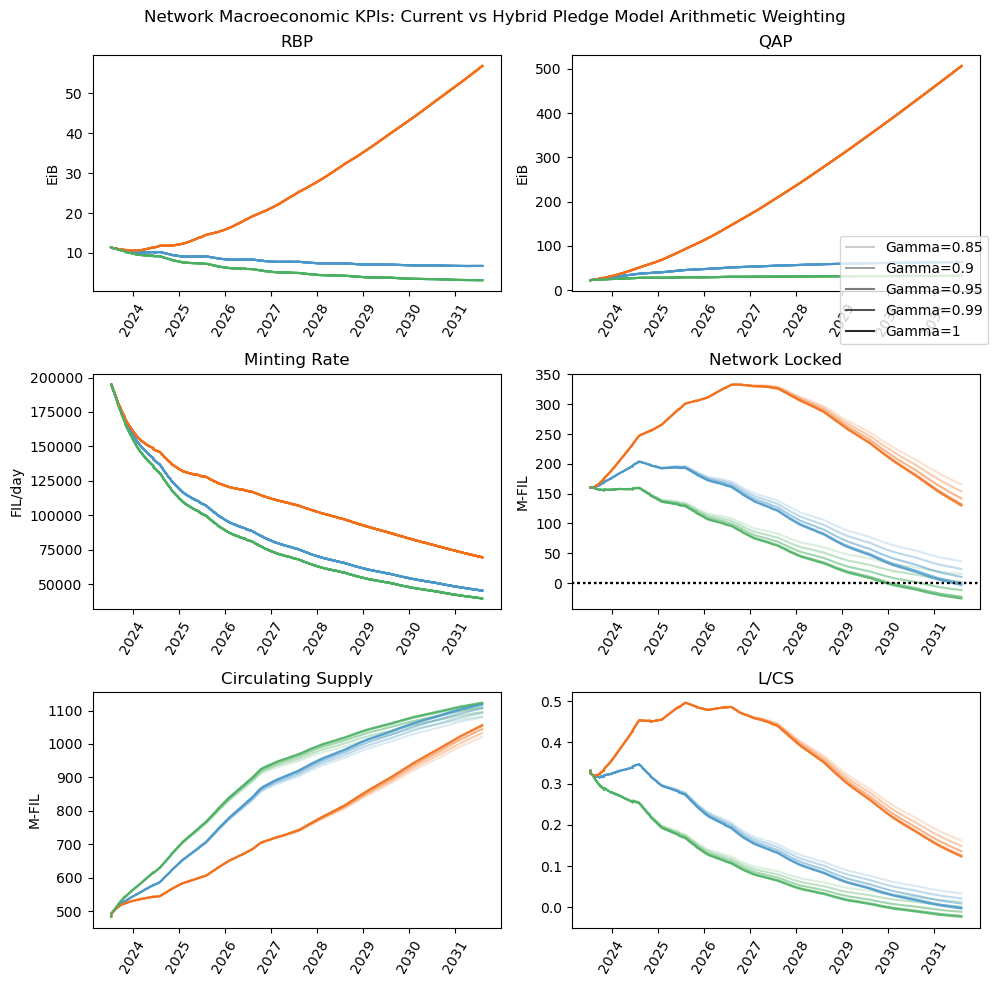

In [137]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Arithmetic'
scenario2results = scenario2results_arithmetic

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

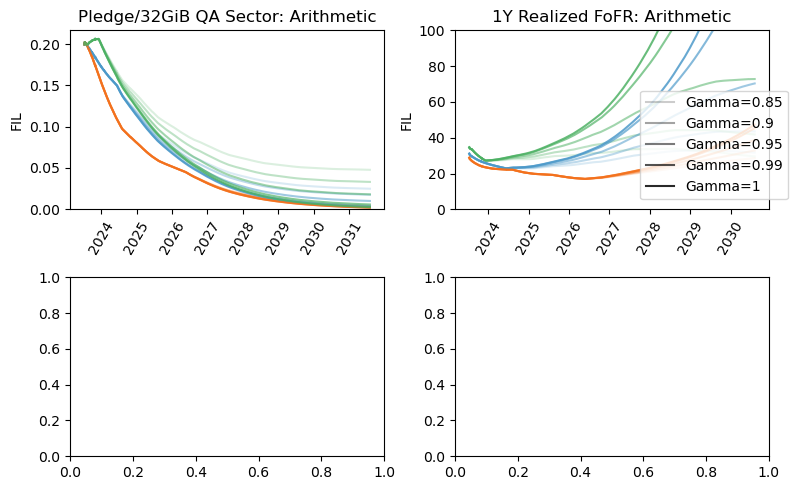

In [138]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Arithmetic'
scenario2results = scenario2results_arithmetic
plot_microeconomic_trajectories(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

In [139]:
# FOFR Adjusted 
beta = 0.4

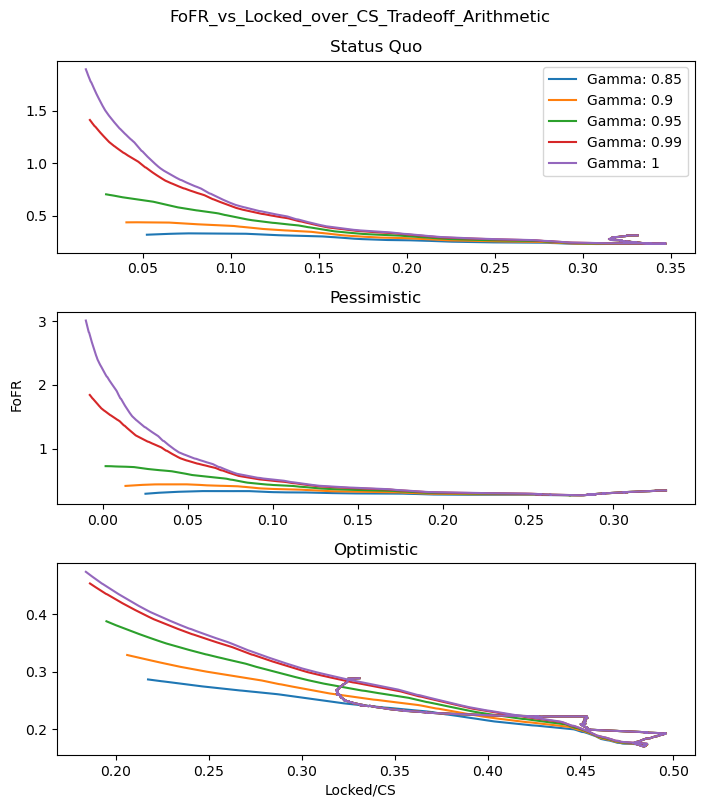

In [140]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_arithmetic.keys(): 
    res_status_quo = scenario2results_arithmetic[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_arithmetic[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_arithmetic[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Arithmetic'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

    

In [141]:
import os
os.getcwd()

'/Users/vkalghatgi/Dropbox/Protocol_Labs/mechafil-jax-notebooks/baseline_project/Hybrid_Consensus_Pledge'

In [150]:
## OBjective F
## Max Onboarding and 
## better to have linear growth and protect consensus than to have exponential growth 
## with weak locking / pledge 

### Geometric

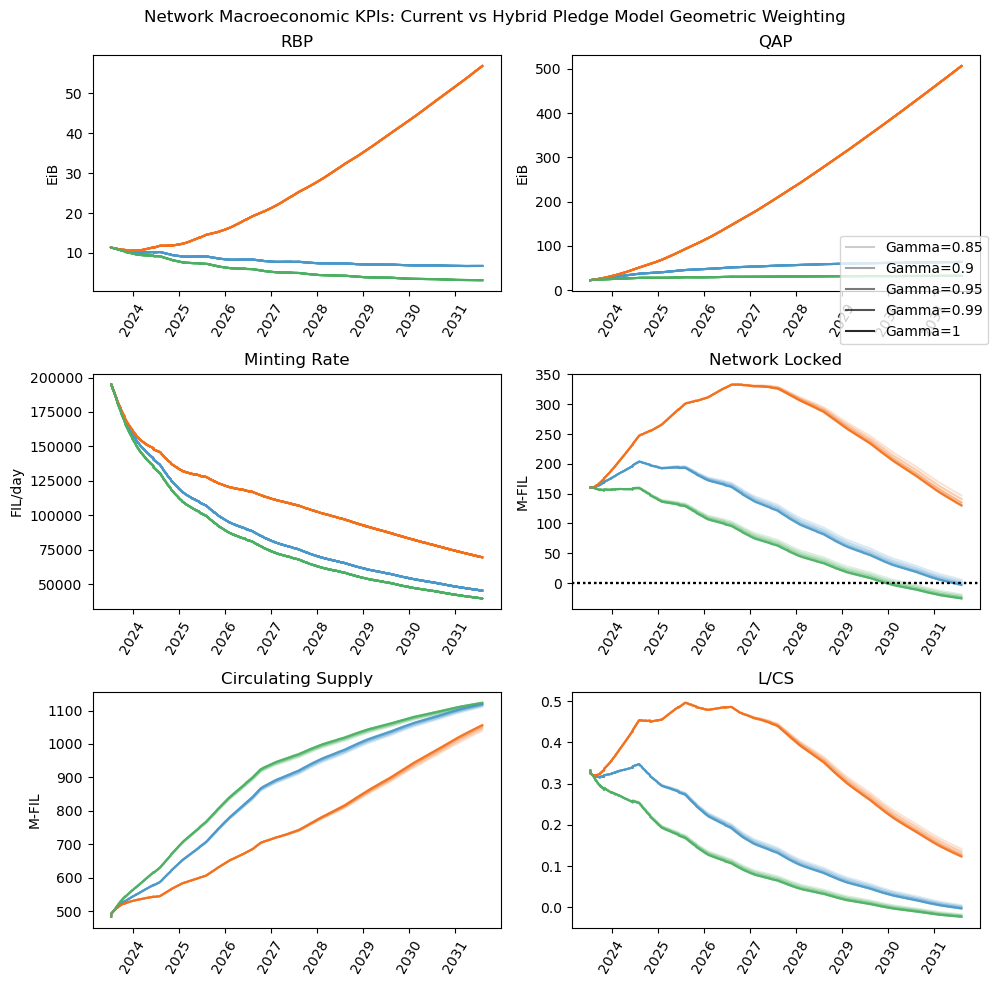

In [142]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Geometric'
scenario2results = scenario2results_geometric

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

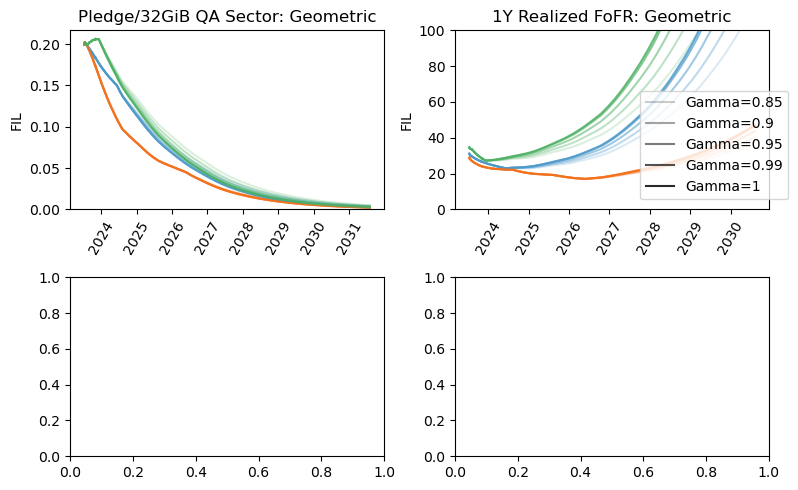

In [143]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Geometric'
scenario2results = scenario2results_geometric
plot_microeconomic_trajectories(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

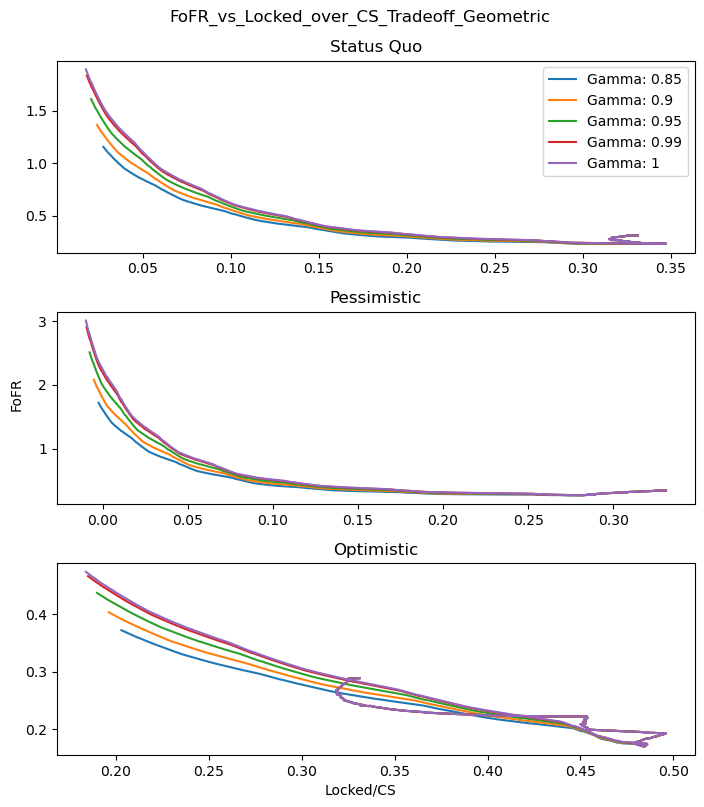

In [144]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_geometric.keys(): 
    res_status_quo = scenario2results_geometric[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_geometric[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_geometric[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Geometric'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

### Harmonic

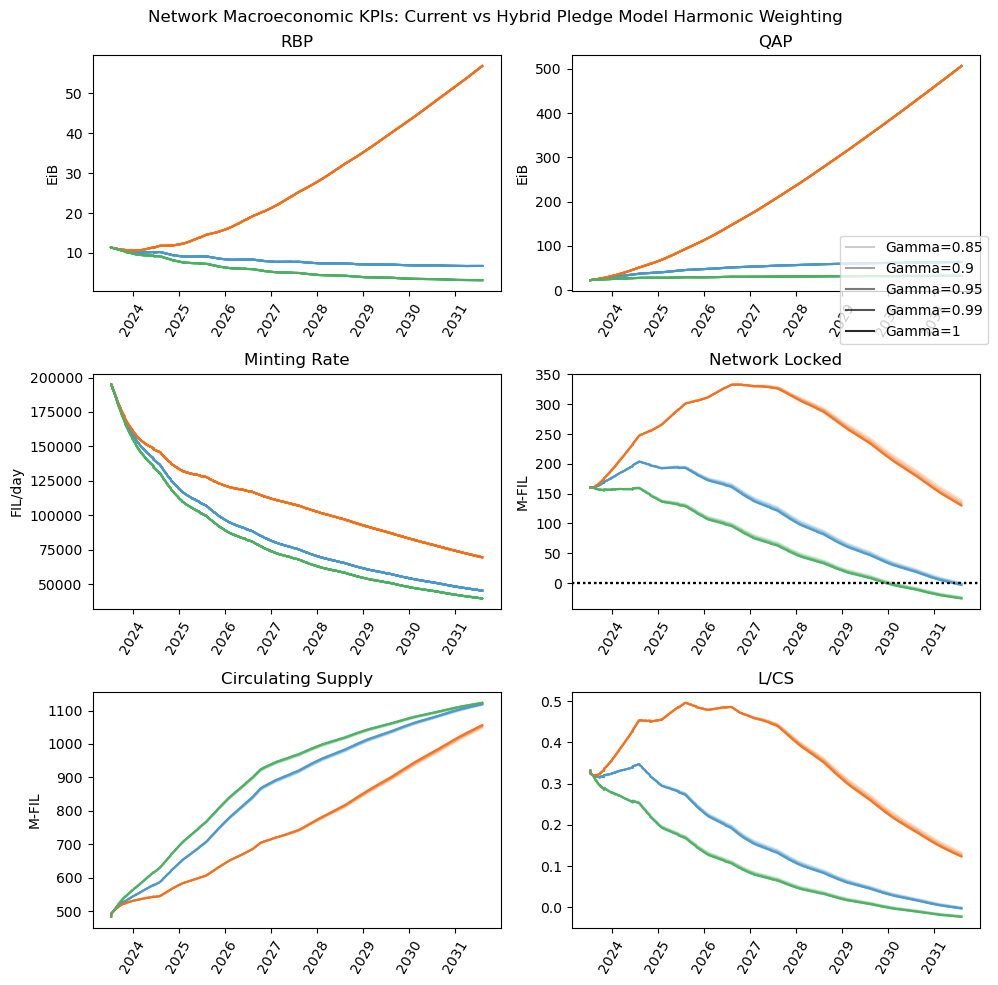

In [145]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Harmonic'
scenario2results = scenario2results_harmonic

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

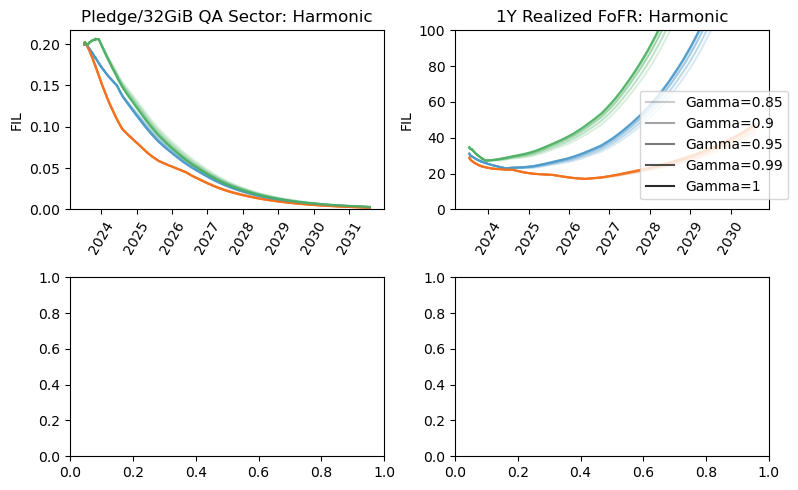

In [146]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Harmonic'
scenario2results = scenario2results_harmonic
plot_microeconomic_trajectories(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

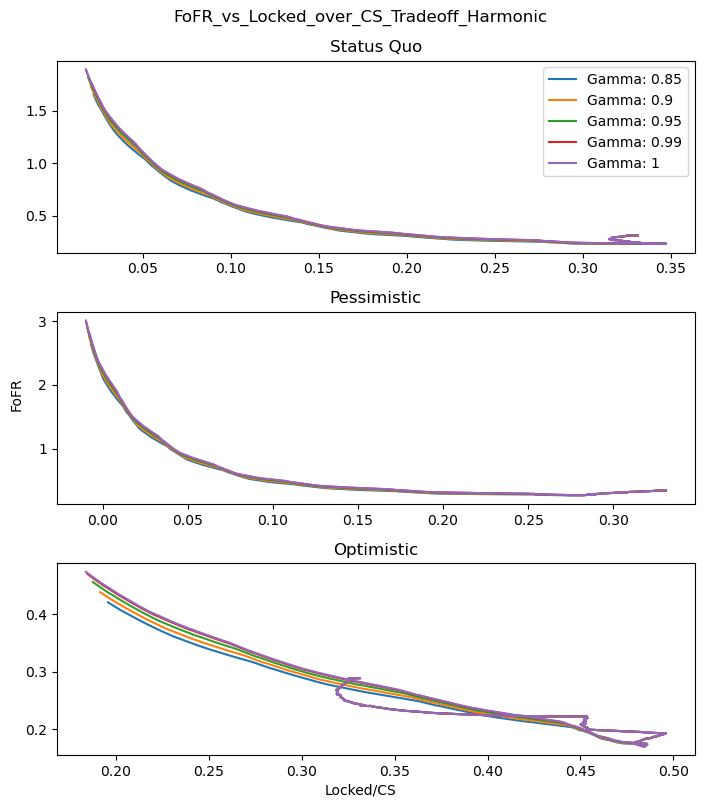

In [147]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_harmonic.keys(): 
    res_status_quo = scenario2results_harmonic[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_harmonic[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_harmonic[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Harmonic'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

## Deprecated

### Geometric Weighting

In [31]:

#plt.show()